In this notebook I am going to implement Sequence to Sequence model from this [paper](https://arxiv.org/abs/1409.3215)

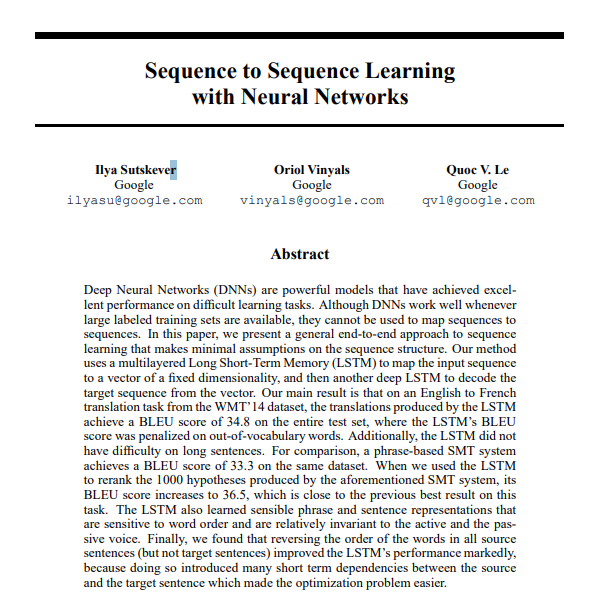

In [1]:
!nvidia-smi

Sun Nov  2 11:26:27 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   40C    P8              9W /   70W |       1MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

input  lib  working


In [ ]:
!pip install nltk
! pip install torch==2.2.0 torchtext
! pip install portalocker==2.8.2

In [4]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchtext.datasets import Multi30k
from nltk.tokenize import WordPunctTokenizer
from collections import Counter
from torchtext.vocab import vocab as Vocab
from torch.nn.utils.rnn import pad_sequence
from torch.nn.utils import clip_grad_norm_
from torch.utils.tensorboard import SummaryWriter
from tqdm.auto import tqdm, trange
import nltk
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu, SmoothingFunction
import random

2025-11-02 11:21:49.374384: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762082509.590809      77 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762082509.654264      77 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
train_data = list(Multi30k(split='train', language_pair=('de', 'en')))

print(f"Number of training examples: {len(train_data)}")
print(train_data[0])

Number of training examples: 29001
('Zwei junge weiße Männer sind im Freien in der Nähe vieler Büsche.', 'Two young, White males are outside near many bushes.')


In [ ]:
tokenizer = WordPunctTokenizer()
tokenizer.tokenize('faran is good')

['faran', 'is', 'good']

In [ ]:
src,trg =  train_data[0]
print("Source = ",src)
print("Target = ",trg)
print(tokenizer.tokenize(trg.rstrip().lower()))

Source =  Zwei junge weiße Männer sind im Freien in der Nähe vieler Büsche.
Target =  Two young, White males are outside near many bushes.
['two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.']


In [ ]:
def tokenize(text):
  return tokenizer.tokenize(text.rstrip().lower())

In [ ]:
src_counter = Counter()
trg_counter = Counter()
for src,trg in train_data:
  src_counter.update(tokenize(src))
  trg_counter.update(tokenize(trg))
src_vocab = Vocab(src_counter, min_freq = 2)
trg_vocab = Vocab(trg_counter,min_freq = 2)

In [ ]:
unk_token = "<unk>"
for vocab in [src_vocab,trg_vocab]:
  if unk_token not in vocab:
    vocab.insert_token(unk_token,index=0)
    vocab.set_default_index(0)

In [ ]:
sos_token, end_token, pad_token = "<sos>", "<eos>", "<pad>"
specials  = [sos_token,end_token,pad_token]
for vocab in [src_vocab,trg_vocab]:
  for token in specials:
    if token not in  vocab:
      vocab.append_token(token)

In [ ]:
print(f"Unique tokens in src (de) vocablary = ",len(src_vocab))
print(f'Unique tokens in trg (en) vocablary =',len(trg_vocab))

Unique tokens in src (de) vocablary =  7892
Unique tokens in trg (en) vocablary = 5903


In [ ]:
src, trg = train_data[0]

In [ ]:
trg_vocab

Vocab()

In [ ]:
tokenized = [sos_token] + tokenize(trg) + [end_token]
encoded = trg_vocab.lookup_indices(tokenized)
[(tok, idx) for tok,idx in zip(tokenized, encoded)]

[('<sos>', 5900),
 ('two', 1),
 ('young', 2),
 (',', 3),
 ('white', 4),
 ('males', 5),
 ('are', 6),
 ('outside', 7),
 ('near', 8),
 ('many', 9),
 ('bushes', 10),
 ('.', 11),
 ('<eos>', 5901)]

In [ ]:
def encode(sent,vocab):
  tokenized = [sos_token] + tokenize(sent) + [end_token]
  encoded = vocab.lookup_indices(tokenized)
  return encoded
encode(src,src_vocab)

[7889, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 7890]

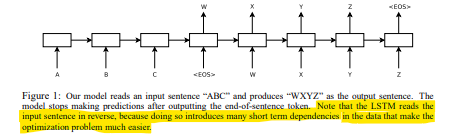

In [ ]:
print(encode(src,src_vocab)[::-1])
print(encode(trg,trg_vocab))

[7890, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 7889]
[5900, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 5901]


In [ ]:
def collate_batch(batch):
  src_list, trg_list = [],[]
  for src, trg in batch:
    src_encoded = encode(src,src_vocab)[::-1] #reversed the source here because of the original paper
    src_list.append(torch.tensor(src_encoded))

    trg_encoded = encode(trg,trg_vocab)
    trg_list.append(torch.tensor(trg_encoded))

  src_padded = pad_sequence(src_list,padding_value=src_vocab[pad_token])
  trg_padded = pad_sequence(trg_list,padding_value=trg_vocab[pad_token])

  return src_padded, trg_padded

In [ ]:
batch_size = 256
train_loader = DataLoader(train_data,batch_size=batch_size,collate_fn=collate_batch,shuffle=True)
src_batch, trg_batch = next(iter(train_loader))
src_batch.shape, trg_batch.shape

(torch.Size([30, 256]), torch.Size([27, 256]))

In [ ]:
val_data = list(Multi30k(split='valid', language_pair=('de','en')))
val_loader = DataLoader(val_data,batch_size=256,shuffle=True,collate_fn=collate_batch)

In [ ]:
class Encoder(nn.Module):
  def __init__(self,n_tokens,emb_dim,hid_dim,n_layers,dropout):
    super().__init__()
    self.n_tokens = n_tokens
    self.hid_dim = hid_dim
    self.n_layers = n_layers
    pad_idx_src = src_vocab['<pad>']
    self.embedding = nn.Embedding(n_tokens,emb_dim, padding_idx = pad_idx_src)
    self.dropout = nn.Dropout(dropout)
    self.rnn = nn.LSTM(emb_dim,hid_dim,n_layers,dropout=dropout)

  def forward(self,src):
    embedded = self.embedding(src)
    embedded = self.dropout(embedded)
    _, hidden = self.rnn(embedded)
    return hidden


In [ ]:
class Decoder(nn.Module):
  def __init__(self, n_tokens,emb_dim,hid_dim,n_layers,dropout):
    super().__init__()
    self.n_tokens = n_tokens
    self.hid_dim = hid_dim
    self.n_layers = n_layers
    pad_idx_trg = trg_vocab['<pad>']
    self.embedding = nn.Embedding(n_tokens, emb_dim, padding_idx = pad_idx_trg)
    self.dropout = nn.Dropout(dropout)
    self.rnn = nn.LSTM(emb_dim,hid_dim,n_layers,dropout=dropout)
    self.out = nn.Linear(hid_dim,n_tokens)
  def forward(self,input,hidden):
    input = input.unsqueeze(dim=0)
    embedded = self.embedding(input)
    embedded = self.dropout(embedded)
    output,hidden = self.rnn(embedded,hidden)
    pred = self.out(output.squeeze(dim=0))
    return pred, hidden

In [ ]:
class Seq2Seq(nn.Module):
  def __init__(self,encoder,decoder):
    super().__init__()
    self.encoder = encoder
    self.decoder = decoder

    assert encoder.hid_dim == decoder.hid_dim, "Encoder and Decoder must have same hidden dim"
    assert (encoder.n_layers == decoder.n_layers), "Encoder and Decoder should have same layer size"

  def forward(self,src,trg,teacher_forcing_ratio = 0.5):
    batch_size = trg.shape[1]
    trg_len = trg.shape[0]

    trg_vocab_size = self.decoder.n_tokens
    preds = []

    hidden = self.encoder(src)
    input = trg[0,:]

    for i in range(1,trg_len):
      pred, hidden = self.decoder(input,hidden)
      preds.append(pred)
      teacher_force = random.random() < teacher_forcing_ratio
      _, top_pred = pred.max(dim=1)
      input = trg[i,:] if teacher_force else top_pred
    return torch.stack(preds)


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
enc = Encoder(len(src_vocab),emb_dim=256,hid_dim=512,n_layers=2,dropout=0.5)
dec = Decoder(len(trg_vocab),emb_dim=256,hid_dim=512,n_layers=2,dropout=0.5)
model = Seq2Seq(enc,dec).to(device)

In [ ]:
def init_weights(m):
  for name, param in m.named_parameters():
    nn.init.uniform_(param,-0.08,0.08)
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(7892, 256, padding_idx=7891)
    (dropout): Dropout(p=0.5, inplace=False)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
  )
  (decoder): Decoder(
    (embedding): Embedding(5903, 256, padding_idx=5902)
    (dropout): Dropout(p=0.5, inplace=False)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (out): Linear(in_features=512, out_features=5903, bias=True)
  )
)

In [ ]:
def count_paramters(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'The total number of trainble parameters are = {count_paramters(model)}')

The total number of trainble parameters are = 13916175


In [ ]:
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index=trg_vocab[pad_token])

In [ ]:
writer = SummaryWriter()
n_epochs = 50
clip = 1
global_step = 0


In [ ]:
for epoch in trange(n_epochs,desc = "Epochs"):
  model.train()
  train_loss = 0
  for src,trg in tqdm(train_loader,desc = "Train",leave=False):
    src,trg = src.to(device), trg.to(device)
    output = model(src,trg)

    output = output.view(-1,output.shape[-1])
    trg = trg[1:].view(-1)
    loss = criterion(output, trg)
    optimizer.zero_grad()
    loss.backward()
    clip_grad_norm_(model.parameters(),clip)
    optimizer.step()
    train_loss += loss.item()
    writer.add_scalar("Training/loss",loss.item(),global_step)
    global_step += 1
  train_loss /= len(train_loader)
  writer.add_scalar("Evaluation/train_loss",train_loss,epoch)

  model.eval()
  val_loss = 0
  for src,trg in tqdm(val_loader,desc="Val",leave = False):
    src,trg = src.to(device), trg.to(device)
    output = model(src,trg)
    output = output.view(-1,output.shape[-1])
    trg = trg[1:].view(-1)
    loss = criterion(output,trg)
    val_loss += loss.item()

  val_loss /= len(val_loader)
  writer.add_scalar("Evaluation/val_loss",val_loss,epoch)



Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Train:   0%|          | 0/114 [00:00<?, ?it/s]

Val:   0%|          | 0/4 [00:00<?, ?it/s]

Train:   0%|          | 0/114 [00:00<?, ?it/s]

Val:   0%|          | 0/4 [00:00<?, ?it/s]

Train:   0%|          | 0/114 [00:00<?, ?it/s]

Val:   0%|          | 0/4 [00:00<?, ?it/s]

Train:   0%|          | 0/114 [00:00<?, ?it/s]

Val:   0%|          | 0/4 [00:00<?, ?it/s]

Train:   0%|          | 0/114 [00:00<?, ?it/s]

Val:   0%|          | 0/4 [00:00<?, ?it/s]

Train:   0%|          | 0/114 [00:00<?, ?it/s]

Val:   0%|          | 0/4 [00:00<?, ?it/s]

Train:   0%|          | 0/114 [00:00<?, ?it/s]

Val:   0%|          | 0/4 [00:00<?, ?it/s]

Train:   0%|          | 0/114 [00:00<?, ?it/s]

Val:   0%|          | 0/4 [00:00<?, ?it/s]

Train:   0%|          | 0/114 [00:00<?, ?it/s]

Val:   0%|          | 0/4 [00:00<?, ?it/s]

Train:   0%|          | 0/114 [00:00<?, ?it/s]

Val:   0%|          | 0/4 [00:00<?, ?it/s]

Train:   0%|          | 0/114 [00:00<?, ?it/s]

Val:   0%|          | 0/4 [00:00<?, ?it/s]

Train:   0%|          | 0/114 [00:00<?, ?it/s]

Val:   0%|          | 0/4 [00:00<?, ?it/s]

Train:   0%|          | 0/114 [00:00<?, ?it/s]

Val:   0%|          | 0/4 [00:00<?, ?it/s]

Train:   0%|          | 0/114 [00:00<?, ?it/s]

Val:   0%|          | 0/4 [00:00<?, ?it/s]

Train:   0%|          | 0/114 [00:00<?, ?it/s]

Val:   0%|          | 0/4 [00:00<?, ?it/s]

Train:   0%|          | 0/114 [00:00<?, ?it/s]

Val:   0%|          | 0/4 [00:00<?, ?it/s]

Train:   0%|          | 0/114 [00:00<?, ?it/s]

Val:   0%|          | 0/4 [00:00<?, ?it/s]

Train:   0%|          | 0/114 [00:00<?, ?it/s]

Val:   0%|          | 0/4 [00:00<?, ?it/s]

Train:   0%|          | 0/114 [00:00<?, ?it/s]

Val:   0%|          | 0/4 [00:00<?, ?it/s]

Train:   0%|          | 0/114 [00:00<?, ?it/s]

Val:   0%|          | 0/4 [00:00<?, ?it/s]

Train:   0%|          | 0/114 [00:00<?, ?it/s]

Val:   0%|          | 0/4 [00:00<?, ?it/s]

Train:   0%|          | 0/114 [00:00<?, ?it/s]

Val:   0%|          | 0/4 [00:00<?, ?it/s]

Train:   0%|          | 0/114 [00:00<?, ?it/s]

Val:   0%|          | 0/4 [00:00<?, ?it/s]

Train:   0%|          | 0/114 [00:00<?, ?it/s]

Val:   0%|          | 0/4 [00:00<?, ?it/s]

Train:   0%|          | 0/114 [00:00<?, ?it/s]

Val:   0%|          | 0/4 [00:00<?, ?it/s]

Train:   0%|          | 0/114 [00:00<?, ?it/s]

Val:   0%|          | 0/4 [00:00<?, ?it/s]

Train:   0%|          | 0/114 [00:00<?, ?it/s]

Val:   0%|          | 0/4 [00:00<?, ?it/s]

Train:   0%|          | 0/114 [00:00<?, ?it/s]

Val:   0%|          | 0/4 [00:00<?, ?it/s]

Train:   0%|          | 0/114 [00:00<?, ?it/s]

Val:   0%|          | 0/4 [00:00<?, ?it/s]

Train:   0%|          | 0/114 [00:00<?, ?it/s]

Val:   0%|          | 0/4 [00:00<?, ?it/s]

Train:   0%|          | 0/114 [00:00<?, ?it/s]

Val:   0%|          | 0/4 [00:00<?, ?it/s]

Train:   0%|          | 0/114 [00:00<?, ?it/s]

Val:   0%|          | 0/4 [00:00<?, ?it/s]

Train:   0%|          | 0/114 [00:00<?, ?it/s]

Val:   0%|          | 0/4 [00:00<?, ?it/s]

Train:   0%|          | 0/114 [00:00<?, ?it/s]

Val:   0%|          | 0/4 [00:00<?, ?it/s]

Train:   0%|          | 0/114 [00:00<?, ?it/s]

Val:   0%|          | 0/4 [00:00<?, ?it/s]

Train:   0%|          | 0/114 [00:00<?, ?it/s]

Val:   0%|          | 0/4 [00:00<?, ?it/s]

Train:   0%|          | 0/114 [00:00<?, ?it/s]

Val:   0%|          | 0/4 [00:00<?, ?it/s]

Train:   0%|          | 0/114 [00:00<?, ?it/s]

Val:   0%|          | 0/4 [00:00<?, ?it/s]

Train:   0%|          | 0/114 [00:00<?, ?it/s]

Val:   0%|          | 0/4 [00:00<?, ?it/s]

Train:   0%|          | 0/114 [00:00<?, ?it/s]

Val:   0%|          | 0/4 [00:00<?, ?it/s]

Train:   0%|          | 0/114 [00:00<?, ?it/s]

Val:   0%|          | 0/4 [00:00<?, ?it/s]

Train:   0%|          | 0/114 [00:00<?, ?it/s]

Val:   0%|          | 0/4 [00:00<?, ?it/s]

Train:   0%|          | 0/114 [00:00<?, ?it/s]

Val:   0%|          | 0/4 [00:00<?, ?it/s]

Train:   0%|          | 0/114 [00:00<?, ?it/s]

Val:   0%|          | 0/4 [00:00<?, ?it/s]

Train:   0%|          | 0/114 [00:00<?, ?it/s]

Val:   0%|          | 0/4 [00:00<?, ?it/s]

Train:   0%|          | 0/114 [00:00<?, ?it/s]

Val:   0%|          | 0/4 [00:00<?, ?it/s]

Train:   0%|          | 0/114 [00:00<?, ?it/s]

Val:   0%|          | 0/4 [00:00<?, ?it/s]

Train:   0%|          | 0/114 [00:00<?, ?it/s]

Val:   0%|          | 0/4 [00:00<?, ?it/s]

Train:   0%|          | 0/114 [00:00<?, ?it/s]

Val:   0%|          | 0/4 [00:00<?, ?it/s]

Train:   0%|          | 0/114 [00:00<?, ?it/s]

Val:   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
trg_itos = trg_vocab.get_itos()
model.eval()
max_len = 50
with torch.no_grad():
  for src,ref in val_data[:10]:
    encoded = encode(src,src_vocab)[::-1]
    encoded = torch.tensor(encoded)[:,None].to(device)
    hidden = model.encoder(encoded)

    pred_tokens = [trg_vocab[sos_token]]
    for _ in range(max_len):
      decoder_input = torch.tensor([pred_tokens[-1]]).to(device)
      pred, hidden= model.decoder(decoder_input, hidden)
      _, pred_token = pred.max(dim=1)
      if pred_token == trg_vocab[end_token]:
        break
      pred_tokens.append(pred_token.item())
    print(f'src: {src.rstrip().lower()}')
    print(f'trg: {ref.rstrip().lower()}')
    print(f'pred: {" ".join(trg_itos[i] for i in pred_tokens[1:])}')
    print()



src: eine gruppe von männern lädt baumwolle auf einen lastwagen
trg: a group of men are loading cotton onto a truck
pred: group of men are using some items on a truck .

src: ein mann schläft in einem grünen raum auf einem sofa.
trg: a man sleeping in a green room on a couch.
pred: a man sleeps on a couch in a green blanket .

src: ein junge mit kopfhörern sitzt auf den schultern einer frau.
trg: a boy wearing headphones sits on a woman's shoulders.
pred: a baby with headphones sits behind to another man on the cellphone .

src: zwei männer bauen eine blaue eisfischerhütte auf einem zugefrorenen see auf
trg: two men setting up a blue ice fishing hut on an iced over lake
pred: two men are a large raft on a large or boat .

src: ein mann mit beginnender glatze, der eine rote rettungsweste trägt, sitzt in einem kleinen boot.
trg: a balding man wearing a red life jacket is sitting in a small boat.
pred: a balding man wearing a blue hat sits on a small boat holding a canoe .

src: eine frau

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
def evaluate_bleu(model,data, src_vocab, trg_vocab, max_len=1, num_samples=100):
  model.eval()
  trg_itos = trg_vocab.get_itos()
  smoothie = SmoothingFunction().method4
  refrences = []
  hypotheses = []

  with torch.no_grad():
    for i, (src,ref) in enumerate(data[:num_samples]):
      encoded = encode(src,src_vocab)[::-1]
      encoded = torch.tensor(encoded)[:,None].to(device)
      hidden = model.encoder(encoded)

      pred_tokens = [trg_vocab[sos_token]]
      for _ in range(max_len):
        decoder_input = torch.tensor([pred_tokens[-1]]).to(device)
        pred, hidden = model.decoder(decoder_input,hidden)
        _, pred_token = pred.max(dim=1)
        pred_token = pred_token.item()
        if pred_token == trg_vocab[end_token]:
          break
        pred_tokens.append(pred_token)

      pred_words = [trg_itos[j] for j in pred_tokens[1:]]
      ref_words = tokenize(ref)

      refrences.append([ref_words])
      hypotheses.append(pred_words)

      if i < 5:
        print(f'src: {src}')
        print(f'trg: {ref}')
        print(f'pred: {' '.join(pred_words)}')
        print()

  bleu = corpus_bleu(refrences,hypotheses,smoothing_function=smoothie)
  return bleu

In [ ]:
bleu = evaluate_bleu(model, val_data, src_vocab, trg_vocab, max_len=50, num_samples=100)
print(f'Bleu Score  =  {bleu * 100:.2f}')

src: Eine Gruppe von Männern lädt Baumwolle auf einen Lastwagen
trg: A group of men are loading cotton onto a truck
pred: group of men are using some items on a truck .

src: Ein Mann schläft in einem grünen Raum auf einem Sofa.
trg: A man sleeping in a green room on a couch.
pred: a man sleeps on a couch in a green blanket .

src: Ein Junge mit Kopfhörern sitzt auf den Schultern einer Frau.
trg: A boy wearing headphones sits on a woman's shoulders.
pred: a baby with headphones sits behind to another man on the cellphone .

src: Zwei Männer bauen eine blaue Eisfischerhütte auf einem zugefrorenen See auf
trg: Two men setting up a blue ice fishing hut on an iced over lake
pred: two men are a large raft on a large or boat .

src: Ein Mann mit beginnender Glatze, der eine rote Rettungsweste trägt, sitzt in einem kleinen Boot.
trg: A balding man wearing a red life jacket is sitting in a small boat.
pred: a balding man wearing a blue hat sits on a small boat holding a canoe .

Bleu Score  = 